# Consumer Business Complaints Analysis (PROCONS - Sindec 2022)

This project explores the 2022 dataset of consumer complaints registered in Brazilian PROCONs, made available through the National Consumer Secretariat (Sindec / Ministry of Justice).

The main objectives are:

* Thematic Clustering - Using Natural Language Processing (NLP) techniques and KMeans clustering to identify recurring topics and group similar complaints. This helps uncover the most common consumer dissatisfaction themes, such as overcharging, poor service, or contractual issues.

* Predictive Modeling - Building a supervised machine learning model using Random Forest to predict whether a complaint will be resolved (Atendida) or not. The model uses structured features from the dataset and aims to assist regulatory agencies and companies in risk assessment and complaint triage.

The notebook includes all steps from data cleaning, preprocessing, feature engineering, to model training, evaluation, and cluster interpretation, with visualizations and insights.

## Importing Libraries

We start by importing essential libraries for: 

* Data manipulation (Pandas, NumPy)

* Visualization (Seaborn, Matplotlib)

* Modeling (Scikit-learn)

* Natural Language Processing (nltk)

Then we follow by loading the consumer complaints dataset into a pandas DataFrame. 

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from collections import Counter
import re

nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pichau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
complaints = pd.read_csv('../data/consumer_complaints_PROCONS_Sindec.csv', sep=';', encoding='utf-8-sig', on_bad_lines='skip')
complaints.drop('CEPConsumidor', axis=1, inplace=True)
complaints.head()

,AnoCalendario,DataArquivamento,DataAbertura,CodigoRegiao,Regiao,UF,strRazaoSocial,strNomeFantasia,Tipo,NumeroCNPJ,...,NomeFantasiaRFB,CNAEPrincipal,DescCNAEPrincipal,Atendida,CodigoAssunto,DescricaoAssunto,CodigoProblema,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor
0,2022,NaN,NaN,5,Centro-oeste,MT,BOOKPLAY,NaN,1,NaN,...,NaN,NaN,NaN,N,63,Financeira,NaN,NaN,NaN,Nao Informada
1,2022,2022-06-27 10:57:04.000,2021-12-01 13:18:11.000,1,Norte,PA,SEGUROS SURA S/A,SEGUROS SURA S/A,1,3.306570e+13,...,NaN,6512000.0,SEGUROS NÃO-VIDA,N,95,"Aparelho de Som ( Gravador, 3x1, CD )",2496.0,Produto com vício,M,entre 21 a 30 anos
2,2022,2022-06-06 10:39:02.000,2021-10-27 11:00:05.000,1,Norte,PA,TELEFÔNICA BRASIL S/A,VIVO,1,2.558157e+12,...,NaN,6110801.0,SERVIÇOS DE TELEFONIA FIXA COMUTADA - STFC,S,186,Telefonia Fixa ( Plano de Expansão / Compra e ...,3745.0,Cobrança indevida/abusiva,F,entre 61 a 70 anos
3,2022,2022-01-05 11:21:09.000,2021-09-24 10:08:06.000,1,Norte,PA,BANCO MERCANTIL DO BRASIL S/A,BMB,1,1.718404e+13,...,NaN,6422100.0,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",S,53,Banco comercial,6915.0,Crédito Consignado,F,entre 51 a 60 anos
4,2022,2022-04-11 11:42:24.000,2019-08-28 14:28:51.000,1,Norte,TO,VIA VAREJO S/A,VIA VAREJO S/A,1,3.304126e+13,...,NaN,NaN,NaN,N,88,Acessório para Aparelho Eletrônico/Pilha/Elétr...,2489.0,Produto com vício,F,entre 51 a 60 anos


Below is a brief description of key fields from the Sindec (Cadastro Nacional de Reclamações Fundamentadas – 2022) dataset, used in this project:

| Field Name              | Description (English)                                                               |
| ----------------------- | ----------------------------------------------------------------------------------- |
| 'AnoCalendario'         | Calendar year of the complaint archive report.                                      |
| 'DataAbertura'          | Opening date of the complaint (when the consumer filed it).                         |
| 'DataArquivamento'      | Archive date of the complaint (when the case was closed).                           |
| 'CodigoRegiao'          | Numeric code for the region of the PROCON: 01-North, 02-Northeast, etc.             |
| 'Regiao'                | Geographic region of the PROCON that handled the complaint.                         |
| 'UF'                    | Federal unit (state) of the PROCON.                                                 |
| 'strRazaoSocial'        | Registered legal name of the supplier (company).                                    |
| 'strNomeFantasia'       | Trade name (commercial/brand name) of the supplier.                                 |
| 'NumeroCNPJ'            | National company identifier (CNPJ) or personal CPF number.                          |
| 'RadicalCNPJ'           | First 8 digits of CNPJ, used to group main company and its branches.                |
| 'RazaoSocialRFB'        | Company name according to the Receita Federal (tax authority).                      |
| 'NomeFantasiaRFB'       | Trade name from Receita Federal records.                                            |
| 'CNAEPrincipal'         | National classification code for the supplier’s main economic activity.             |
| 'DescCNAEPrincipal'     | Description of the CNAE activity code.                                              |
| 'CodigoAssunto'         | Numerical code of the general subject of the complaint.                             |
| 'DescricaoAssunto'      | Description of the complaint subject (e.g., product or service type).               |
| 'CodigoProblema'        | Numerical code of the specific problem reported.                                    |
| 'DescricaoProblema'     | Description of the consumer's reported issue (e.g., overcharging, contract breach). |
| 'Atendida'              | Whether the complaint was resolved (S = Yes, N = No).                               |
| 'SexoConsumidor'        | Gender of the consumer: M = Male, F = Female, N = Not applicable.                   |
| 'FaixaEtariaConsumidor' | Age range of the consumer (e.g., 21–30, 31–40, etc.).                               |

## Feature Engineering

### Dropping Irrelevant or Redundant Columns

In this step, we remove several columns from the dataset that are either:

* Identifiers (e.g., CNPJ, company names),

* Redundant or highly correlated fields (e.g., multiple company name formats or CNAE codes),

* Non-informative for modeling (e.g., region codes, calendar year),

Removing these columns helps simplify the dataset and prevent data leakage. 

In [74]:
complaints.drop(['AnoCalendario', 'CodigoRegiao', 'strNomeFantasia', 
                 'NumeroCNPJ', 'RadicalCNPJ', 'RazaoSocialRFB', 'NomeFantasiaRFB', 
                 'CNAEPrincipal', 'DescCNAEPrincipal', 'CodigoAssunto', 'CodigoProblema'
                ], axis=1,inplace=True)

pd.set_option('future.no_silent_downcasting', True)
complaints['Atendida'] = complaints['Atendida'].replace({'S':1, 'N':0})

complaints[['DataArquivamento', 'DataAbertura']] = complaints[['DataArquivamento', 'DataAbertura']].apply(pd.to_datetime)

complaints.head()

,DataArquivamento,DataAbertura,Regiao,UF,strRazaoSocial,Tipo,Atendida,DescricaoAssunto,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor
0,NaT,NaT,Centro-oeste,MT,BOOKPLAY,1,0,Financeira,NaN,NaN,Nao Informada
1,2022-06-27 10:57:04,2021-12-01 13:18:11,Norte,PA,SEGUROS SURA S/A,1,0,"Aparelho de Som ( Gravador, 3x1, CD )",Produto com vício,M,entre 21 a 30 anos
2,2022-06-06 10:39:02,2021-10-27 11:00:05,Norte,PA,TELEFÔNICA BRASIL S/A,1,1,Telefonia Fixa ( Plano de Expansão / Compra e ...,Cobrança indevida/abusiva,F,entre 61 a 70 anos
3,2022-01-05 11:21:09,2021-09-24 10:08:06,Norte,PA,BANCO MERCANTIL DO BRASIL S/A,1,1,Banco comercial,Crédito Consignado,F,entre 51 a 60 anos
4,2022-04-11 11:42:24,2019-08-28 14:28:51,Norte,TO,VIA VAREJO S/A,1,0,Acessório para Aparelho Eletrônico/Pilha/Elétr...,Produto com vício,F,entre 51 a 60 anos


In [75]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68289 entries, 0 to 68288
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DataArquivamento       68286 non-null  datetime64[ns]
 1   DataAbertura           68286 non-null  datetime64[ns]
 2   Regiao                 68289 non-null  object        
 3   UF                     68289 non-null  object        
 4   strRazaoSocial         68289 non-null  object        
 5   Tipo                   68289 non-null  int64         
 6   Atendida               68289 non-null  object        
 7   DescricaoAssunto       68289 non-null  object        
 8   DescricaoProblema      68249 non-null  object        
 9   SexoConsumidor         68275 non-null  object        
 10  FaixaEtariaConsumidor  68289 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 5.7+ MB


From info() we can observe that from a total of 68289 entries, 'DescricaoProblema' has 68249 non-null. 'SexoConsumidor', 'DataArquivamento' and 'DataAbertura' also have missing data.

Below, we present the features with missing values along with the corresponding amount of missing data.

In [76]:
complaints.isnull().sum()

DataArquivamento          3
DataAbertura              3
Regiao                    0
UF                        0
strRazaoSocial            0
Tipo                      0
Atendida                  0
DescricaoAssunto          0
DescricaoProblema        40
SexoConsumidor           14
FaixaEtariaConsumidor     0
dtype: int64

In [77]:
complaints.dropna(inplace=True)

The missing data represents less than 0,0005% of the data. For this reason, dropping them would be acceptable.

## Exploratory Data Analysis (EDA)

We will begin with the analysis of the categorical variables by using `.describe(include='object')`. This results in a table containing:

* count: Total number of non-null values.

* unique: Number of unique values in the column.

* top: Most frequent value in the column.

* freq: Frequency of the most common value.

This method gives an idea of ​​the distribution of variables, helping with the choice of appropriate treatments, like normalization, transformation, etc.

In [78]:
complaints.describe(include='object')

,Regiao,UF,strRazaoSocial,Atendida,DescricaoAssunto,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor
count,68239,68239,68239,68239,68239,68239,68239,68239
unique,5,17,18942,2,218,186,3,8
top,Centro-oeste,CE,ENERGISA MATO GROSSO -DISTRIBUIDORA DE ENERGIA...,0,Banco comercial,Cobrança indevida.,F,entre 31 a 40 anos
freq,23304,18469,1114,36698,7331,8984,33959,12785


* The features 'Regiao' and 'UF' indicate that the most common geographic region for complaints is Centro-Oeste, with the state CE (Ceará) being the most frequently reported.

* The company with highest number of occurrences is ENERGISA MATO GROSSO.

* The top complaint problem is Cobrança indevida, which stands for incorrect or improper billing.

* The subject with the highest occurrence is banco comercial (commercial bank).

* The majority of consumers filing complaints are female, predominantly in the 31 to 40 years old age range.

* Most complaints remain unresolved.


### Resolved vs Unresolved Complaints:

Now, we will analyze the distribution of resolved versus unresolved complaints across various features, where '0' stands for 'No', and '1' for 'Yes'.

#### Counts

Text(0.5, 1.0, 'Distribution of Resolved vs Unresolved Complaints')

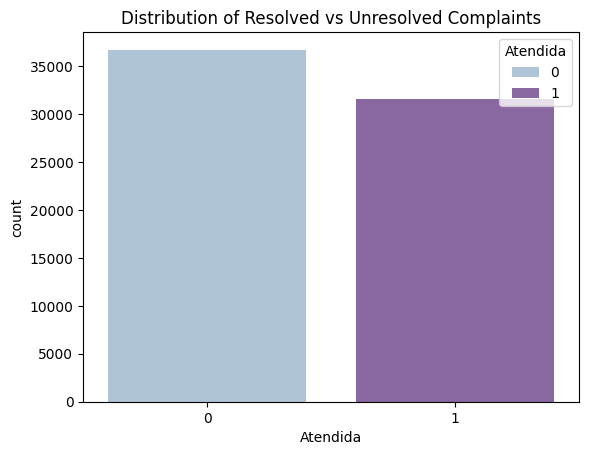

In [79]:
sns.countplot(complaints, x='Atendida', hue='Atendida', palette='BuPu', legend=True)
plt.title('Distribution of Resolved vs Unresolved Complaints')

We can observe that a larger number of complaints were not resolved compared to those that were. This suggests that a significant portion of customer issues remained unresolved, which may indicate inefficiencies in customer service or a lack of responsiveness from companies.

#### Customer's Sex

Let’s examine how complaints classified as Resolved or Unresolved are distributed according to the customer’s sex.

<Axes: xlabel='SexoConsumidor', ylabel='count'>

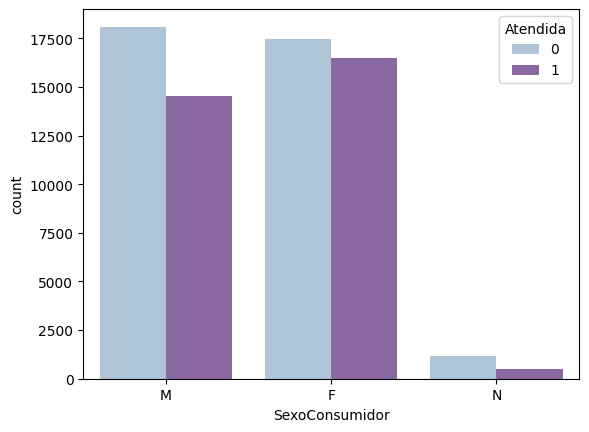

In [80]:
sns.countplot(complaints, x='SexoConsumidor', hue='Atendida', palette='BuPu', legend=True)

The chart displays the distribution of complaints categorized by customer sex (SexoConsumidor) and whether the complaint was resolved (1) or unresolved (0):

* Male consumers (M) submitted the highest number of complaints overall. However, a significant portion of these complaints was unresolved.

* Female consumers (F) also submitted a large number of complaints, with a slightly higher rate of resolved cases compared to males.

* Complaints marked with N ("Not applicable") are much fewer, and the majority of them were unresolved.

This suggests that while both male and female consumers experience unresolved issues, female complaints tend to be resolved slightly more often than male ones.

#### Age Range

The chart shows how complaints are distributed across different age ranges and whether they were resolved (1) or unresolved (0):

* The age group 31 to 40 years old has the highest number of complaints overall, with a noticeable gap between unresolved and resolved cases, with most complaints in this group were not resolved.

* Other highly represented age groups include 41 to 50, 51 to 60, and 61 to 70 years old, with relatively balanced levels of resolved and unresolved complaints.

* Consumers over 70 and under 20 submitted fewer complaints, but most still tended to be unresolved.

* A significant number of complaints fall under the “Not applicable” category for age, where unresolved cases are clearly more prevalent.

This suggests that while people in their 30s are the most active in filing complaints, they also experience the highest rate of unresolved issues.



<Axes: xlabel='FaixaEtariaConsumidor', ylabel='count'>

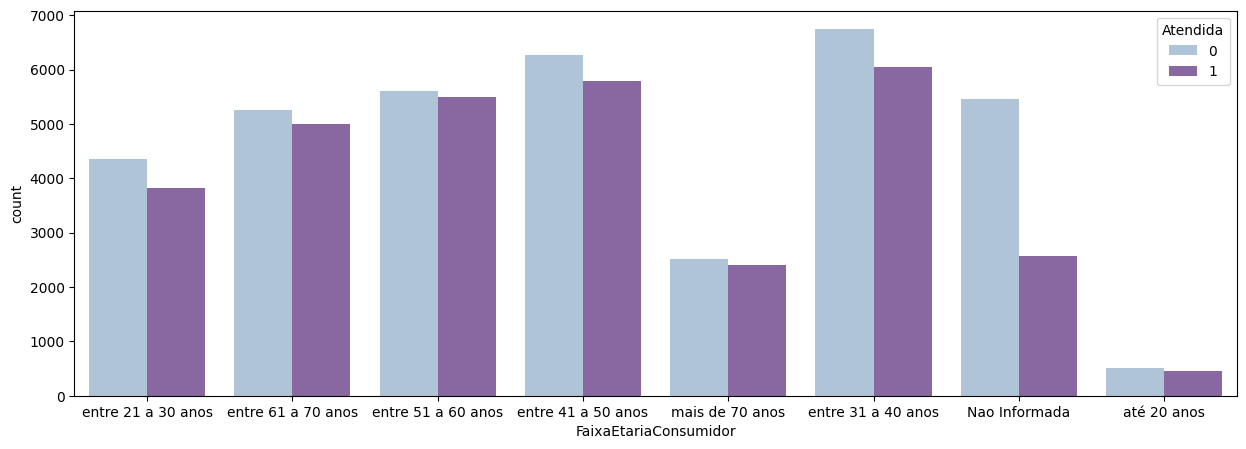

In [81]:
plt.figure(figsize=(15,5))
sns.countplot(complaints, x='FaixaEtariaConsumidor', hue='Atendida', palette='BuPu', legend=True)

#### Region

The chart shows the distribution of complaints across Brazil’s geographic regions

* The Centro-Oeste region has the highest number of complaints overall, with a considerable gap where many complaints remain unresolved.

* The Nordeste region also shows a high volume of complaints, with a similar pattern: more complaints are unresolved than resolved.

* In the Sudeste and Sul regions, the total number of complaints is lower, and the difference between resolved and unresolved complaints is also smaller, though unresolved cases still lead.

* Interestingly, the Norte region is the only one where resolved complaints outnumber unresolved ones, despite having the fewest total complaints.

This suggests that Centro-Oeste and Nordeste are the most critical regions in terms of volume and service response issues, while the Norte shows relatively better responsiveness.

<Axes: xlabel='Regiao', ylabel='count'>

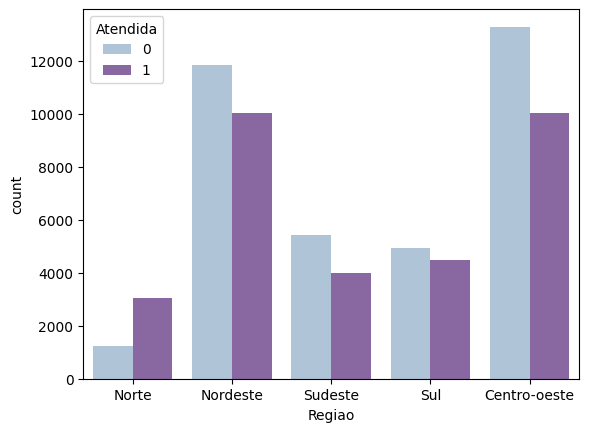

In [82]:
sns.countplot(complaints, x='Regiao', hue='Atendida', palette='BuPu', legend=True)

We can see below the most frequent problem descriptions (DescricaoProblema) along with the companies most commonly associated with each issue.

In [83]:
main_complaints_by_region = complaints.groupby(['Regiao','DescricaoProblema','strRazaoSocial']).size().reset_index(name='Count')
main_complaints_by_region = main_complaints_by_region[main_complaints_by_region['Regiao']=='Centro-oeste'].sort_values('Count', ascending=False)
main_complaints_by_region.head(5)

,Regiao,DescricaoProblema,strRazaoSocial,Count
1564,Centro-oeste,Cobrança indevida/abusiva,ENERGISA MATO GROSSO -DISTRIBUIDORA DE ENERGIA...,985
1368,Centro-oeste,Cobrança indevida/abusiva,AGUAS CUIABA S.A. CONCES. SERV. PUB. AGUA E ES...,250
8487,Centro-oeste,Produto com vício,SAMSUNG ELETRONICA DA AMAZONIA LTDA,129
1742,Centro-oeste,Cobrança indevida/abusiva,OI S/A,115
1571,Centro-oeste,Cobrança indevida/abusiva,ENERGISA MATO GROSSO-DISTRIBUIDORA DE ENERGIA S/A,102


In [84]:
main_complaints_by_region = complaints.groupby(['Regiao','DescricaoProblema','strRazaoSocial']).size().reset_index(name='Count')
main_complaints_by_region = main_complaints_by_region[main_complaints_by_region['Regiao']=='Nordeste'].sort_values('Count', ascending=False)
main_complaints_by_region.head(5)

,Regiao,DescricaoProblema,strRazaoSocial,Count
14574,Nordeste,Cobrança indevida/abusiva,CAGECE,470
14816,Nordeste,Cobrança indevida/abusiva,OI MOVEL S/A,407
14622,Nordeste,Cobrança indevida/abusiva,COMPANHIA ENERGETICA DO CEARÁ,401
19961,Nordeste,Produto com vício,SAMSUNG ELETRONICA DA AMAZONIA LTDA,234
14617,Nordeste,Cobrança indevida/abusiva,COMPANHIA DE AGUA E ESGOTO DO CEARA,200


In [85]:
main_complaints_by_region = complaints.groupby(['Regiao','DescricaoProblema','strRazaoSocial']).size().reset_index(name='Count')
main_complaints_by_region = main_complaints_by_region[main_complaints_by_region['Regiao']=='Sudeste'].sort_values('Count', ascending=False)
main_complaints_by_region.head(5)

,Regiao,DescricaoProblema,strRazaoSocial,Count
25872,Sudeste,Cobrança indevida/abusiva,OI S.A. - EM RECUPERACAO JUDICIAL,122
25756,Sudeste,Cobrança indevida/abusiva,CLARO S.A.,82
28753,Sudeste,Produto com vício,SAMSUNG ELETRONICA DA AMAZONIA LTDA,80
26894,Sudeste,Crédito Consignado,BANCO PAN S/A,79
26840,Sudeste,Crédito Consignado,BANCO BMG S/A,69


In [86]:
main_complaints_by_region = complaints.groupby(['Regiao','DescricaoProblema','strRazaoSocial']).size().reset_index(name='Count')
main_complaints_by_region = main_complaints_by_region[main_complaints_by_region['Regiao']=='Sul'].sort_values('Count', ascending=False)
main_complaints_by_region.head(5)

,Regiao,DescricaoProblema,strRazaoSocial,Count
32086,Sul,Crédito Consignado,BANCO PAN S.A. - CIP,122
32045,Sul,Crédito Consignado,BANCO BMG SA - CIP,61
34171,Sul,Produto com vício,SAMSUNG ELETRONICA DA AMAZONIA LTDA,60
32058,Sul,Crédito Consignado,BANCO C6 CONSIGNADO S.A.,47
31229,Sul,Cobrança indevida/abusiva,OI MÓVEL S.A,41


In [87]:
main_complaints_by_region = complaints.groupby(['Regiao','DescricaoProblema','strRazaoSocial']).size().reset_index(name='Count')
main_complaints_by_region = main_complaints_by_region[main_complaints_by_region['Regiao']=='Norte'].sort_values('Count', ascending=False)
main_complaints_by_region.head(5)

,Regiao,DescricaoProblema,strRazaoSocial,Count
23049,Norte,Cobrança indevida/abusiva,COMPANHIA DE SANEAMENTO DO PARÁ,71
23026,Norte,Cobrança indevida/abusiva,14 BRASIL TELECOM CELULAR S/A,51
23050,Norte,Cobrança indevida/abusiva,COMPANHIA DE SANEAMENTO DO TOCANTINS,39
23840,Norte,"Garantia (Abrangência, cobertura, etc.)",NOSSO LAR LOJAS DE DEPARTAMENTO LTDA,38
23978,Norte,Não entrega do produto (titulo de capitalizaçã...,CONSÓRCIO NACIONAL HONDA LTDA,36


We can see that the most frequent complaints are related to improper billing, with ENERGISA MATO GROSSO standing out as the company with the highest number of cases (985 complaints).

### Top Companies with Most Complaints

We can see below the top 20 companies with highest number of complaints

In [88]:
# Companies and its complaints counts 
complaints['strRazaoSocial'].value_counts().head(20)

strRazaoSocial
ENERGISA MATO GROSSO -DISTRIBUIDORA DE ENERGIA S.A    1114
OI MOVEL S/A                                           780
SAMSUNG ELETRONICA DA AMAZONIA LTDA                    747
CAIXA ECONOMICA FEDERAL                                696
COMPANHIA ENERGETICA DO CEARÁ                          657
CAGECE                                                 624
CLARO S/A                                              596
BANCO SANTANDER (BRASIL) S.A.                          482
MAGAZINE LUIZA S/A                                     411
BANCO BMG SA                                           396
BANCO BRADESCO SA                                      391
BANCO BRADESCO S.A.                                    341
BANCO BRADESCARD S.A.                                  324
CLARO S.A.                                             314
BANCO BMG S/A                                          310
BANCO PAN S.A.                                         302
BANCO DO BRASIL S.A                      

We can notice that BANCO BRADESCO SA and BANCO BRADESCO S.A. refer to the same company, but were counted separately due to formatting differences in the company name.

To address this inconsistency, we applied a transformation to standardize the names by replacing "SA" with "S.A." using the following line of code:

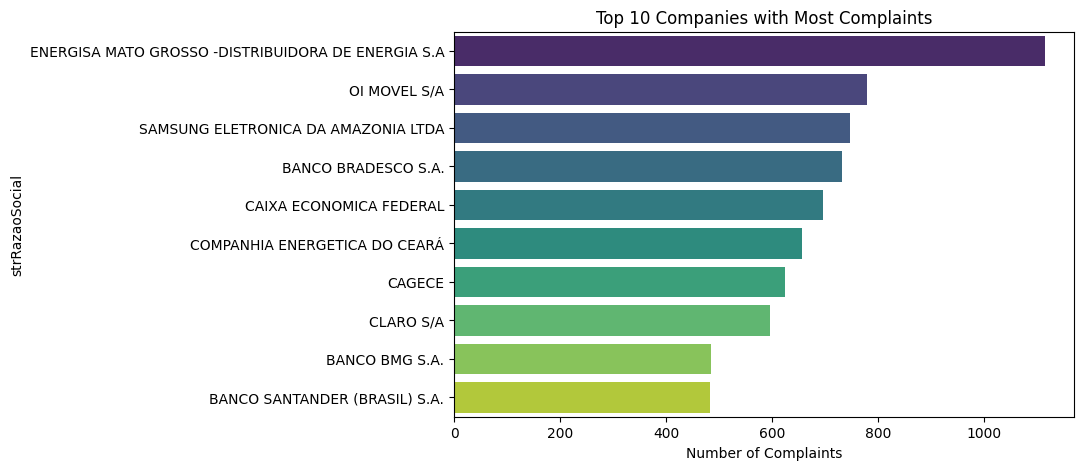

In [89]:
complaints['strRazaoSocial'] = complaints['strRazaoSocial'].str.replace(r'\bSA\b', 'S.A.', regex=True)

top_companies = complaints['strRazaoSocial'].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_companies.values, y=top_companies.index, hue=top_companies.index, palette='viridis', legend=False)
plt.title("Top 10 Companies with Most Complaints")
plt.xlabel("Number of Complaints")
plt.show()

#### Time in Months between Opening and Filing Date 

To analyze how long it takes for complaints to be officially filed after being opened, we can create a new feature called Tempo em Meses (Time in Months). This is calculated using the difference in months between the opening date (DataAbertura) and the filing date (DataArquivamento)

In [90]:
complaints['Tempo em Meses'] = (complaints['DataArquivamento'].dt.year - complaints['DataAbertura'].dt.year) * 12 + (complaints['DataArquivamento'].dt.month - complaints['DataAbertura'].dt.month)

We then filter the data to include only complaints that took 96 months (8 years) or less to be filed, in order to focus on more realistic time frames

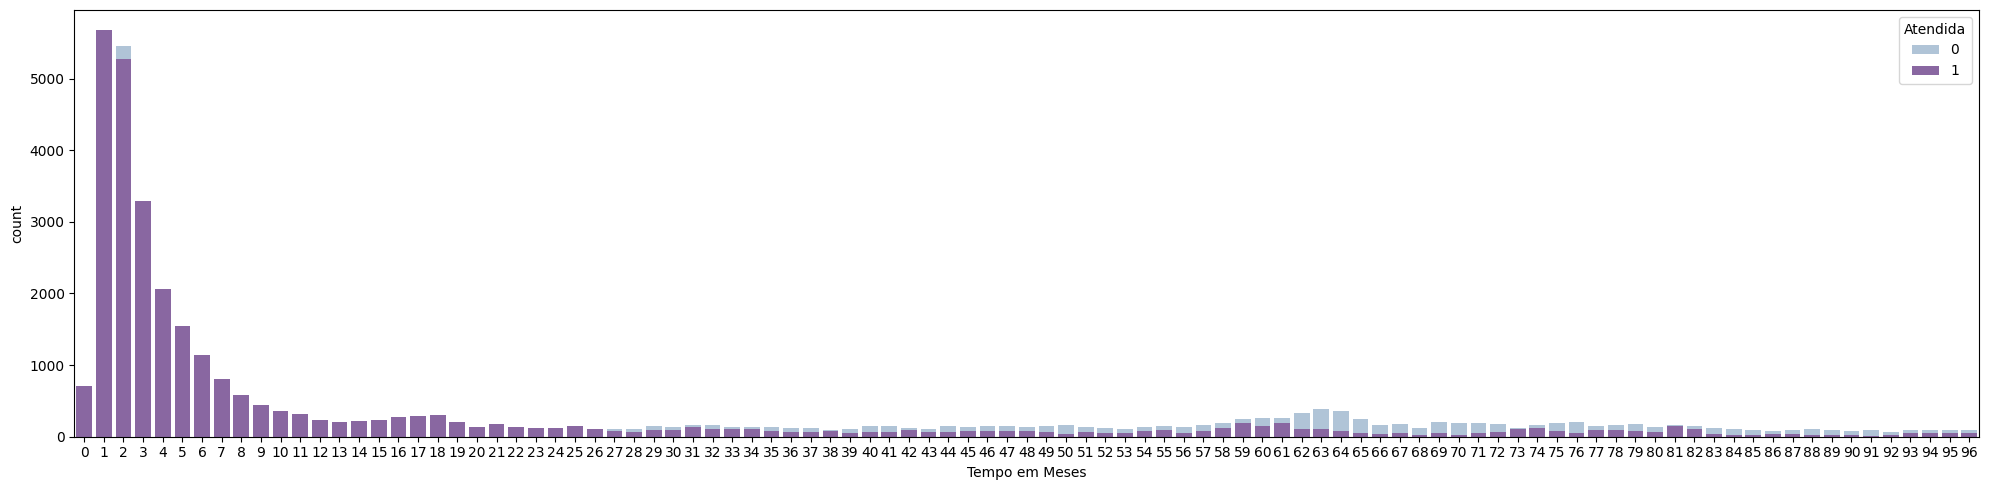

In [91]:
filtered_complaints = complaints[complaints['Tempo em Meses'] <=96]

plt.figure(figsize=(20,5))
sns.countplot(filtered_complaints, x='Tempo em Meses', hue='Atendida', dodge=False, palette='BuPu', legend=True) 
plt.tight_layout()

As we can see:

* Most complaints are filed within the first 3 months after being opened. These early filings are also the ones with the highest attendance rate.

* After month 3, the number of filings drops sharply, and the number of unresolved cases become higher than the resolved ones.

This suggests that speed of filing is correlated with higher resolution rates, emphasizing the importance of prompt action in complaint handling.

#### What Have We Discoverd So Far?

Through our exploratory data analysis, we have identified several key insights regarding customer complaints:

* Geographic Distribution:

    * The region with the highest number of complaints is Centro-Oeste, followed closely by Nordeste.

    * The state with the most complaints is CE (Ceará).

    * In all regions except Norte, unresolved complaints outnumber resolved ones, highlighting issues with customer service responsiveness in most parts of the country.

* Top Companies:

    * The company with the highest number of complaints is ENERGISA MATO GROSSO.

* Complaint Types:

    * The most frequent complaint type is Cobrança indevida (incorrect or improper billing).

    * The top subject area (DescricaoAssunto) is banco comercial (commercial bank).

* Customer Profile:

    * The majority of complaints come from female consumers, especially those aged 31 to 40 years.

    * Complaints with undisclosed gender or age tend to have lower resolution rates.

* Resolution Rates:

    * Overall, there are more unresolved complaints than resolved ones, suggesting a high rate of unresolved issues.

    * The Centro-Oeste and Nordeste regions show particularly high volumes of unresolved complaints.

* Time Between Opening and Filing:

    * Most complaints are filed within the first 3 months of being opened.

    * Complaints filed earlier tend to have a higher chance of being resolved.

    * After the initial months, the number of filings drops significantly, and resolution rates become more balanced.



## Natural Language Processing

With the exploratory data analysis complete, we will now move on to building and evaluating clustering and predictive models based on the available features.

In [92]:
complaints.head()

,DataArquivamento,DataAbertura,Regiao,UF,strRazaoSocial,Tipo,Atendida,DescricaoAssunto,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor,Tempo em Meses
1,2022-06-27 10:57:04,2021-12-01 13:18:11,Norte,PA,SEGUROS SURA S/A,1,0,"Aparelho de Som ( Gravador, 3x1, CD )",Produto com vício,M,entre 21 a 30 anos,6
2,2022-06-06 10:39:02,2021-10-27 11:00:05,Norte,PA,TELEFÔNICA BRASIL S/A,1,1,Telefonia Fixa ( Plano de Expansão / Compra e ...,Cobrança indevida/abusiva,F,entre 61 a 70 anos,8
3,2022-01-05 11:21:09,2021-09-24 10:08:06,Norte,PA,BANCO MERCANTIL DO BRASIL S/A,1,1,Banco comercial,Crédito Consignado,F,entre 51 a 60 anos,4
4,2022-04-11 11:42:24,2019-08-28 14:28:51,Norte,TO,VIA VAREJO S/A,1,0,Acessório para Aparelho Eletrônico/Pilha/Elétr...,Produto com vício,F,entre 51 a 60 anos,32
5,2022-11-29 09:27:38,2022-05-06 09:16:41,Norte,PA,LIBERTY SEGUROS S/A,1,1,Seguro,Cobrança indevida.,F,entre 41 a 50 anos,6


### Text Pre-processing

In [93]:
def text_process(complaint):

    if not isinstance(complaint, str):
        complaint = str(complaint)

    nopunc = [char for char in complaint if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('portuguese')]

### Clustering Complaints

Now we will group similar complaints using KMeans. The process begins with defining the features (X) and target (y), and splitting the dataset into training and test.

In [94]:
X = complaints['DescricaoProblema']
y = complaints['Atendida']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

Creating a pipeline with KMeans

In [96]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('cluster', KMeans(n_clusters=10, random_state=42))
])

Fitting the pipeline to the training data

In [97]:
pipeline.fit(X_train)

'fit completed'

'fit completed'

#### Analyzing Clustering Complaints

Let's plot the count of samples in each cluster in the training data.

In [98]:
X_train['cluster'] = pipeline['cluster'].labels_

X_test_transformed = pipeline['tfidf'].transform(pipeline['bow'].transform(X_test))
X_test['cluster']  = pipeline['cluster'].predict(X_test_transformed)

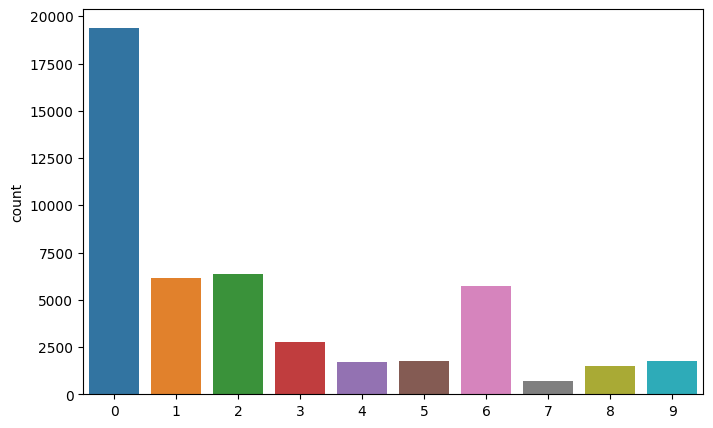

In [99]:
plt.figure(figsize=(8,5))
sns.countplot(x=X_train['cluster'], hue=X_train['cluster'], palette='tab10', legend=False)
plt.show()

#### What the countplot shows?

It displays the distribution of samples across clusters in our X_train set. Each bar shows how many complaints were assigned to each cluster (0 to 11):

* Cluster 0 is by far the largest, with over 19,000 complaints.

* The others have moderate sizes, ranging from ~1,000 to ~6,000.

This indicates that KMeans has formed imbalanced clusters, which is common in real-world data.

Now, let's understand what each cluster represents.

In [100]:
clusters = pipeline['cluster'].labels_

if len(clusters) != len(X_train):
    X_train = X_train.iloc[:len(clusters)].reset_index(drop=True)

for cluster_id in sorted(np.unique(clusters)):
    print(f"\n Cluster {cluster_id} - Complaints Examples:")
    examples = X_train[clusters == cluster_id].drop_duplicates()
    for text in examples:
        print('-', text)



 Cluster 0 - Complaints Examples:
- Vicio de qualidade (mal executado, inadequado, impróprio)
- Outros problemas com contratos de saúde (Não cobertura, abrangência, reembolso)
- Produto com vício
- Defeito/Risco à saúde e segurança
- Recusa injustificada em prestar serviço
- Reajuste abusivo (preço, taxa, mensalidade, etc.)
- Cobrança de valor quando o produto e devolvido (cobrança indevida)
- Prazo de validade (falta, ilegível, etc.)
- Transação Eletrônica Não Reconhecida
- SAC - Cancelamento de serviço (retenção, demora, não envio do comprovante)
- Má prestação de serviço (recusa, mau atendimento, sonegação de mercadoria, venda casada, entrega diferente do pedido)
- Desbloqueio de aparelho
- Não entrega de copia do contrato
- Rescisão do contrato por inadimplência do consumidor
- Garantia - Descumprimento, prazo
- Falha bancaria em transações eletrônicas (transferencias indevidas, saques indevidos)
- Serviço não concluído /Fornecimento parcial
- SAC - Acompanhamento de demandas (aus

We can visualize the proportion of complaints that were addressed or not (Atendida) within each KMeans cluster, using the training set.

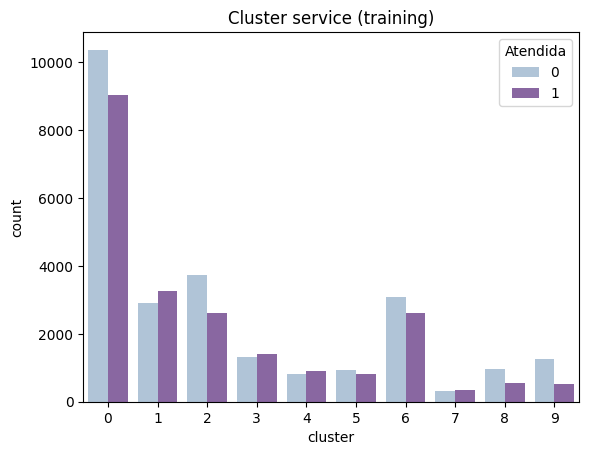

In [101]:
X_train = complaints[['DescricaoProblema']].loc[y_train.index].copy()

X_train_clustered = X_train.copy()
X_train_clustered['Atendida'] = y_train
X_train_clustered['cluster'] = pipeline['cluster'].labels_

sns.countplot(data=X_train_clustered, x='cluster', hue='Atendida', palette='BuPu')
plt.title("Cluster service (training)")
plt.show()

The plot shows:

* X-axis: cluster count

* Bar height: number of complaints in that cluster

* Bar color: split between Atendida=1 (resolved) and Atendida=0 (not resolved)

As we can see, cluster 0 has the highest number of complaints, which mostly are unresolved cases. 

The others have a moderate size, showing a more even distribution between resolved and unresolved cases

#### Most Common Words in Complaints

The barplot below shows the most common words that appear in complaints. As we can see, **cobraça** (billing) is associated with over 24,000 complaints, followed by **indevida** (improper), **produto** (product), **contrato** (contract) and **abusiva** (abusive).

This suggests that companies are failing to address key issues related to billing errors, abusive contractual terms, and product-related problems, which appear to be the primary drivers of customer dissatisfaction. These findings highlight the need for stronger monitoring of billing practices, clearer contractual agreements, and improved product quality control to reduce complaint volumes.

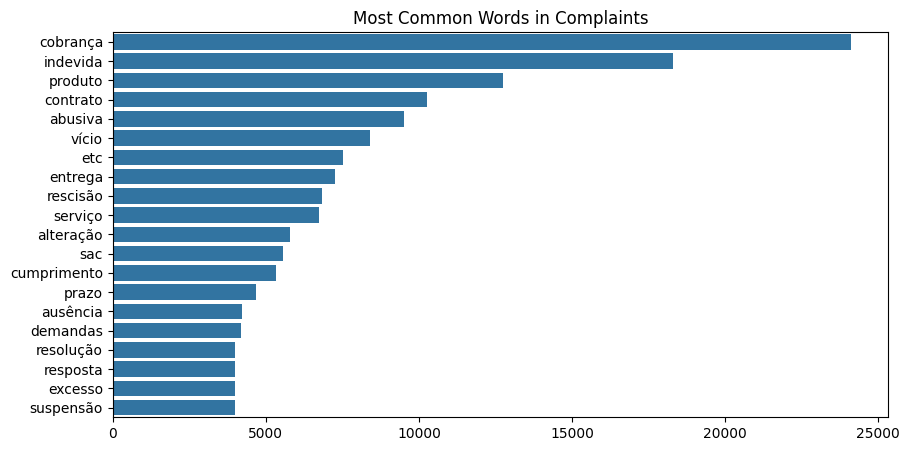

In [102]:
# Joining all descriptions
all_words = ' '.join(complaints['DescricaoProblema'].dropna().astype(str).str.lower())

# Basic cleaning
all_words = re.sub(r'[^a-záéíóúãõâêîôûç ]', ' ', all_words)
all_words = text_process(all_words)

# Counting words
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Visualizing
words, counts = zip(*most_common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words))
plt.title("Most Common Words in Complaints")
plt.show()

We now transition to predictive modeling to assess the likelihood of a complaint being resolved.

### Prediction: Supervised Classification with Random Forest

To predict whether a complaint would be resolved or not, we apply a supervised machine learning approach using the Random Forest classifier. 

After the labeled dataset is split into training and test sets, where the target variable is 'Atendida', indicating whether the complaint was resolved (1) or not (0), it's time to  preprocess and vectorize the complaint descriptions using TF-IDF Vectorizer.

In [103]:
X = complaints[['DescricaoProblema', 'Regiao', 'Tipo', 'SexoConsumidor', 'Tempo em Meses', 'strRazaoSocial', 'FaixaEtariaConsumidor']]
y = complaints['Atendida'].astype(int)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

Observe that X contains text, categorical and numerical columns. In order to be able to use them in a machine learning model, its necessary to preprocess and transform these features into a numerical format compatible with the model. The typical steps are:

* Handle Numerical Columns:

    * Scaling: Normalize or standardize numerical features (e.g., Min-Max scaling, StandardScaler) to help many algorithms perform better.

* Handle Categorical Columns:

    Encoding: Convert categorical variables into numerical representations.

    * If the categorical variable is nominal (no natural order), use One-Hot Encoding.

    * If the categorical variable is ordinal (has a meaningful order), use Ordinal Encoding or map categories to integers based on order.


* Handle Text Columns:

    * Text preprocessing: Clean text by lowercasing, removing punctuation, stopwords, and optionally stemming or lemmatization.

    Feature extraction from text: Transform text into numerical features using techniques such as:

    * Bag-of-Words (CountVectorizer) or TF-IDF Vectorizer, which convert text into sparse vectors.

In [105]:
text_col = 'DescricaoProblema'
cat_cols = ['Regiao', 'SexoConsumidor', 'FaixaEtariaConsumidor', 'strRazaoSocial']
num_cols = ['Tempo em Meses', 'Tipo']

stopwords_pt = stopwords.words('portuguese')

text_transformer = TfidfVectorizer(stop_words=stopwords_pt, max_features=1000)
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()

In [106]:
preprocessor = ColumnTransformer([
    ('text', text_transformer, text_col),
    ('cat', cat_transformer, cat_cols),
    ('num', num_transformer, num_cols)
])

In [107]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

In [108]:
# Setting search parameters
param_grid_rfc = {
    'clf__n_estimators': [100],
    'clf__max_depth': [5, 10, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

It's important to define the objective of this predictive model. Here, we want to analyze the quality of service or detect companies with poor resolution rates. For this reason, reducing false positives is key, because the model incorrectly predicts that a complaint was resolved when it wasn’t. 

This creates a false sense of service quality, hiding actual unresolved issues.

In [109]:
# GridSearchCV Random Forest (hyperparameter tuning)
grid_search_rfc = GridSearchCV(pipeline, param_grid=param_grid_rfc, cv=3, scoring='f1', n_jobs=-1, verbose=2) 
grid_search_rfc.fit(X_train, y_train)

'fit completed'

Fitting 3 folds for each of 12 candidates, totalling 36 fits


'fit completed'

In [110]:
best_model_rfc = grid_search_rfc.best_estimator_

predictions = best_model_rfc.predict(X_test)

The model was trained on the TF-IDF vectors of the training set and evaluated on the test set using metrics such as accuracy, precision, recall, and F1-score.

In [111]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70     10965
           1       0.66      0.61      0.63      9507

    accuracy                           0.67     20472
   macro avg       0.67      0.67      0.67     20472
weighted avg       0.67      0.67      0.67     20472



#### Interpretation

* Precision: When the model predicts a complaint was resolved, it is right about 66% of the time.

* Recall: The model correctly identifies 61% of all resolved cases.

* F1-score: The model balances precision and recall with 63%.

#### Confusion Matrix

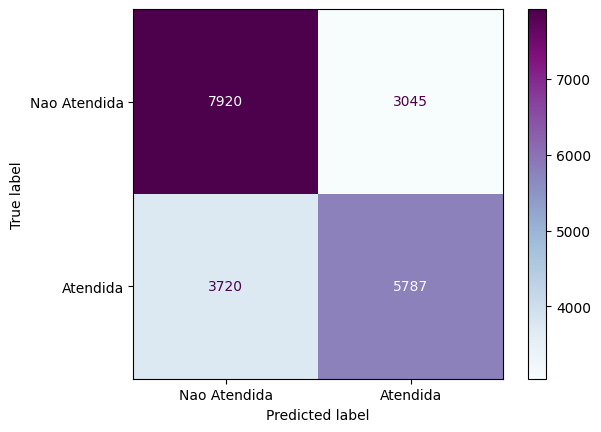

In [112]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm, display_labels=["Nao Atendida", "Atendida"]).plot(cmap='BuPu')

The confusion matrix above takes the form:

|                      | Predicted: Nao Atendida      | Predicted: Atendida         |
| -------------------- | ------------------------ | ------------------------ |
| **Actual: Nao Atendida** | 7920 (True Negative, TN) | 3045 (False Positive, FP) |
| **Actual: Atendida**    | 3720 (False Negative, FN) | 5787 (True Positive, TP)  |

* True Negatives shows that the model correctly predicted "Nao Atendida" for 7920 complaints that indeed were not resolved.

* False Positives shows that the model predicted "Atendida" for 3045 complaints that actually were not resolved. These are false alarms.

* False Negatives shows that the model predicted "Nao Atendida" for 3720 complaints that were actually resolved. These are missed cases.

* True Positives shows that the model correctly predicted "Atendida" for 5787 complaints that were actually resolved.

## Final Insights

* Dominant Complaint Themes

    * The clustering analysis revealed that the majority of complaints are concentrated around billing issues, such as overcharging, improper charges, and contract disputes. Companies from the energy, telecommunications, and water/wastewater sectors are the most frequently associated with these clusters.

* Company-Level Findings

    * Certain companies, such as regional utility providers, show a high concentration of complaints in clusters related to billing disputes and service interruptions.

    * When comparing sectors, energy and telecom stand out for their elevated complaint volumes, while sectors like retail have fewer but more diverse issues.

* Churn Risk Indicators

    * The analysis of unresolved complaints highlighted specific complaint types, particularly improper billing and lack of service response, that correlate strongly with dissatisfaction. These issues represent potential churn drivers, especially in competitive markets like telecom.

* Predictive Modeling Insights

    * The Random Forest model achieved solid predictive performance, demonstrating that structured features (e.g., company, sector, complaint type, and region) can be leveraged to forecast whether a complaint will be resolved.

* Actionable Recommendations

    * For companies: Prioritize resolving billing-related disputes quickly and improve communication with consumers in high-risk clusters.

    * For regulators: Focus on companies or sectors with a high rate of unresolved complaints, as these are likely sources of recurring consumer dissatisfaction.